INFO:2025-07-21 21:52:57,985:jax._src.xla_bridge:945: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-07-21 21:52:57,988:jax._src.xla_bridge:945: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/homebrew/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)


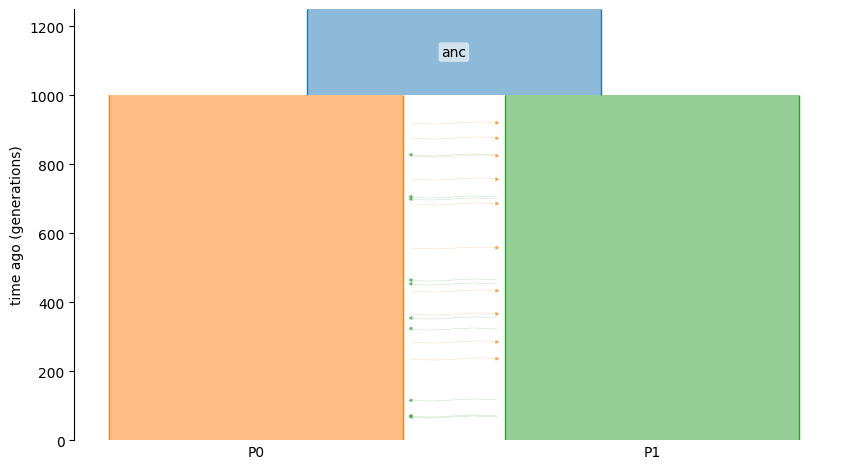

In [4]:
import msprime as msp
import demes
import demesdraw

q_anc = 1e4
q0 = 1e4
q1 = 1e4
m = 0.0001
tau = 1000
demo = msp.Demography()
demo.add_population(initial_size= q_anc, name = "anc")
demo.add_population(initial_size = q0, name = "P0")
demo.add_population(initial_size = q1, name = "P1")
demo.set_symmetric_migration_rate(populations=("P0", "P1"), rate= m)
tmp = [f"P{i}" for i in range(2)]
demo.add_population_split(time = tau, derived=tmp, ancestral="anc")
g = demo.to_demes()
demesdraw.tubes(g)
# print(g)
sample_size = 10
samples = {f"P{i}": sample_size for i in range(2)}
anc = msp.sim_ancestry(samples=samples, demography=demo, recombination_rate=1e-8, sequence_length=1e7, random_seed=42)
ts = msp.sim_mutations(anc, rate=1e-8, random_seed=42)

import jax.random as jr
import numpy as np
import random
key = jr.PRNGKey(0)

In [5]:
import jax.numpy as jnp

key, subkey = jr.split(key)

num_pop = 2
sample_config = {f"P{i}": 0 for i in range(num_pop)}
# BECAUSE I DON'T SPLIT SUBKEY THE SAMPLE CHOSEN IS FIXED
samples = jr.choice(subkey, ts.num_samples, shape=(2,), replace=False)
sample1, sample2 = samples.item(0), samples.item(1)

# Please note that the ancestral population by default is population 0
# and any subpopulation increments by 1
pop1 = ts.node(sample1).population - 1
pop2 = ts.node(sample2).population - 1
sample_config[f"P{pop1}"] += 1
sample_config[f"P{pop2}"] += 1
init_vertices = jnp.array([pop1, pop2])

print(init_vertices)
print(sample_config)
print(sample1)
print(sample2)

tmrca_spans = []
current_tmrca = None
current_span_length = 0

for tree in ts.trees():
    span_length = tree.interval.right - tree.interval.left
    
    # Get TMRCA for this pair in current tree
    tmrca = tree.tmrca(sample1, sample2) # tree.tmrca(sample1, sample2) / (4 * Ne)
    
    if current_tmrca is None:
        # First span
        current_tmrca = tmrca
        current_span_length = span_length
    elif tmrca == current_tmrca:
        # Continue current span
        current_span_length += span_length
    else:
        # New span, record the previous one
        tmrca_spans.append(jnp.array([current_tmrca, current_span_length]))
        current_tmrca = tmrca
        current_span_length = span_length
    
# Add the last span
if current_tmrca is not None:
    tmrca_spans.append(jnp.array([current_tmrca, current_span_length]))

tmrca_spans = jnp.array(tmrca_spans)
print(tmrca_spans)

[1 0]
{'P0': 1, 'P1': 1}
22
0
[[ 8281.69558997  1636.        ]
 [28065.11541213   795.        ]
 [22269.2535078   4617.        ]
 ...
 [10628.08249648  1986.        ]
 [16118.07926117  9220.        ]
 [18250.50803671    31.        ]]


In [ ]:
from abc import ABC, abstractmethod, abstractproperty
from dataclasses import dataclass

import interpax
import jax.numpy as jnp
from jaxtyping import Array, ArrayLike, Float, Scalar, ScalarLike


@dataclass(kw_only=True)
class CoalRate(ABC):
    @abstractproperty
    def jumps(self) -> Float[Array, "_"]:
        """Return the times at which the coalescent rate changes discontinuously."""
        pass

    @abstractmethod
    def __call__(self, t: ScalarLike) -> Scalar:
        """Evaluate the coalescent rate at time t."""
        pass

    def R(self, a: ScalarLike, b: ScalarLike) -> Scalar:
        r"""Integrated coalescent rate,

        int_a^b self(t) dt
        """
        pass


@dataclass(kw_only=True)
class PiecewiseConstant(CoalRate):
    """Piecewise constant coalescent rate."""

    c: Float[ArrayLike, "T"]
    t: Float[ArrayLike, "T"]

    @property
    def jumps(self) -> Float[Array, "T"]:
        """Return the times at which the coalescent rate changes discontinuously."""
        return jnp.array(self.t)

    @property
    def _ppoly(self) -> interpax.PPoly:
        return interpax.PPoly(self.c[None], jnp.append(self.t, jnp.inf), check=False)

    def __call__(self, t: ScalarLike) -> Scalar:
        return self._ppoly(t)

    def R(self, a: ScalarLike, b: ScalarLike) -> Scalar:
        return self._ppoly.integrate(a, b)

"Likelihood of an ARG"

import diffrax as dfx
import jax
import jax.numpy as jnp
from jax import vmap
from jax.scipy.special import xlog1py, xlogy
from jaxtyping import Array, Float, Scalar, ScalarLike

def loglik(eta: CoalRate, r: ScalarLike, data: Float[Array, "intervals 2"]) -> Scalar:
    """Compute the log-likelihood of the data given the demographic model.

    Args:
        eta: Coalescent rate at time t.
        r: float, the recombination rate.
        data: the data to compute the likelihood for. The first column is the TMRCA, and
              the second column is the span.

    Notes:
        - Successive spans that have the same TMRCA should be merged into one span:
          <tmrca, span1> + <tmrca, span1> = <tmrca, span + span>.
        - Missing data/padding indicated by span<=0.
    """
    times, spans = data.T
    i = times.argsort()
    sorted_times = times[i]

    def f(t, y, _):
        c = eta(t)
        A = jnp.array([[-r, r, 0.0], [c, -2 * c, c], [0.0, 0.0, 0.0]])
        return A.T @ y

    y0 = jnp.array([1.0, 0.0, 0.0])
    solver = dfx.Tsit5()
    term = dfx.ODETerm(f)
    ssc = dfx.PIDController(rtol=1e-6, atol=1e-6, jump_ts=eta.jumps)
    T = times.max()
    sol = dfx.diffeqsolve(
        term,
        solver,
        0.0,
        T,
        dt0=0.001,
        y0=y0,
        stepsize_controller=ssc,
        saveat=dfx.SaveAt(ts=sorted_times),
    )

    # invert the sorting so that cscs matches times
    i_inv = i.argsort()
    cscs = sol.ys[i_inv]

    @vmap
    def p(t0, csc0, t1, csc1, span):
        p_nr_t0, p_float_t0, p_coal_t0 = csc0
        p_nr_t1, p_float_t1, p_coal_t1 = csc1
        # no recomb for first span - 1 positions
        r1 = xlogy(span - 1, p_nr_t0)
        # coalescence at t1
        r2 = jnp.log(eta(t1))
        # back-coalescence process up to t1, depends to t0 >< t1
        r3 = jnp.where(
            t0 < t1, jnp.log(p_float_t0) - eta.R(t0, t1), jnp.log(p_float_t1)
        )
        return r1 + r2 + r3

    ll = p(times[:-1], cscs[:-1], times[1:], cscs[1:], spans[:-1]).sum()
    # for the last position, we only know span was at least as long
    ll += xlogy(spans[-1], cscs[-1, 0])
    return ll

In [10]:
from momi3.momi import Momi3
momi_object = Momi3(g).iicr(2)
# params = [("demes", 0, "epochs", 0, "start_size"), ("demes", 1, "epochs", 0, "start_size")]
params = [("demes", 0, "epochs", 0, "start_size")]
f, x = momi_object.reparameterize(list(params))
print(x)

# a toy example just to run the likelihood once
parameters = list(x.keys())
x[parameters[0]] = np.array(8000.0)
params = x
# We use unique_coalescence_times because we are using every possible unique coalescence time 
# between two sampling configuration
# t = jnp.linspace(1e-4, 100000, 1000)
# c = likelihood(params, t, sample_config)

import jax
import jax.numpy as jnp
import phlash
from phlash.likelihood.arg import log_density

def call_momi(t_value, num_samples, x):
    """Computes c and p from momi_object."""
    c, p = momi_object(t=t_value, num_samples=num_samples, params=f(x))
    return c, p

# Vectorizing over t
batched_call_momi = jax.vmap(call_momi, in_axes=(0, None, None))

def likelihood(x, tmrca_spans, num_samples):
    """Computes the negative log-likelihood (for minimization)."""
    t = jnp.linspace(1e-4, 100000, 1000)
    c_values, log_p_values = batched_call_momi(t, num_samples, x)
    eta = PiecewiseConstant(c=c_values, t=t)
    log_density = loglik(eta, 1e-8, jnp.array(tmrca_spans, dtype=jnp.float64))
    # return -(jnp.sum(jnp.log(c_values) + log_p_values))  # Negative for minimization
    return log_density


{frozenset({('demes', 0, 'epochs', 0, 'end_size'), ('demes', 0, 'epochs', 0, 'start_size')}): Array(10000., dtype=float64)}


{'P0': 1, 'P1': 1}


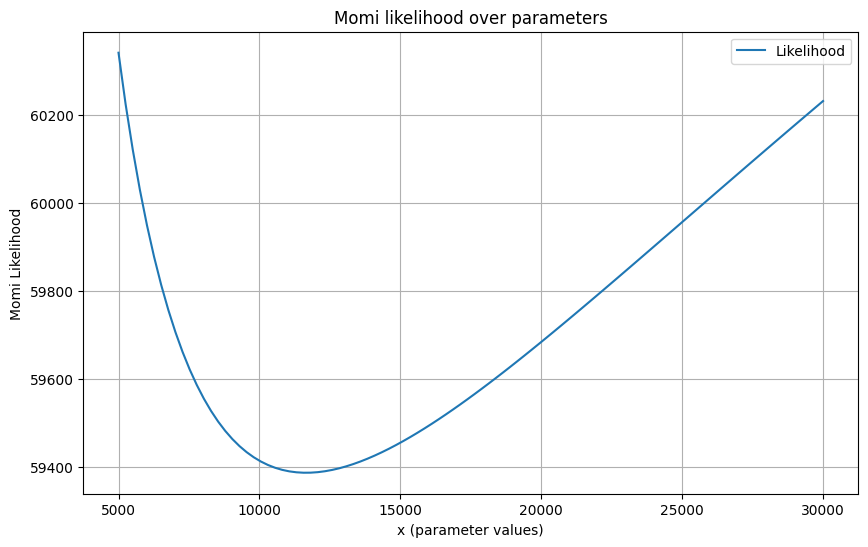

In [13]:
from jax import vmap
x_values = jnp.linspace(5000, 30000, 100)  # adjust these steps as needed

# Vectorize the likelihood computation over x_values
def compute_likelihood(val):
    updated_x = x.copy()
    updated_x[parameters[0]] = val
    params = updated_x
    return -likelihood(params, tmrca_spans, sample_config)

# Use vmap to compute likelihoods for all x_values
likelihoods = vmap(compute_likelihood)(x_values)

print(sample_config)
import matplotlib.pyplot as plt
# Plot
plt.figure(figsize=(10, 6))
plt.plot(x_values, likelihoods, label='Likelihood')
plt.xlabel('x (parameter values)')
plt.ylabel('Momi Likelihood')
plt.title('Momi likelihood over parameters')
plt.legend()
plt.grid(True)
plt.show()